In [1]:
import netket as nk
import numpy as np

from scipy.sparse.linalg import eigsh

from tqdm import tqdm
from functools import partial

import jax
import jax.numpy as jnp
import jax.experimental.sparse as jsparse

from flax import linen as nn # flax is library that brings a more pytorch-like API to JAX
import optax # optax is a library that provides optimizers and learning rate schedules

import matplotlib.pyplot as plt

In [2]:
# defining the hamiltonian on a 4x4 spin lattice

g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

# netket already provides a function to create the hamiltonian for the ising model (which is real valued)
h_nk = nk.operator.Ising(hi, g, h=1.0, J=1.0, dtype=float).to_sparse()

# converting the netket operator to a jax sparse matrix in BCSR format
h = jsparse.BCSR.from_scipy_sparse(h_nk)

In [5]:
ground_energies, ground_states = eigsh(h_nk, k=1)
ground_idx = np.argmin(ground_energies)
ground_energy = ground_energies[ground_idx]
ground_state = ground_states[:, ground_idx]

print(f"Ground Energy: {ground_energy:.5f}")

Ground Energy: -34.01060


In [6]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]

        J = self.param("J", nn.initializers.normal(), (n_sites,n_sites), float)

        dtype = jnp.promote_types(J.dtype, x.dtype)
        J = J.astype(dtype)
        x = x.astype(dtype)

        J_symm = J.T + J
        log_amplitude = jnp.einsum("...i,ij,...j", x, J_symm, x)

        return log_amplitude

In [7]:
def get_amplitudes(model, params):
    configs = hi.all_states()
    log_psi = model.apply(params, configs)
    psi = jnp.exp(log_psi)
    psi_norm = psi / jnp.linalg.norm(psi)
    return psi_norm


def get_energy(model, params, h):
    psi = get_amplitudes(model, params)
    h_exp = psi.conj().T@(h@psi)
    return h_exp


@partial(jax.jit, static_argnames='model')
def get_energy_grad(model, params, h):
    energy_grad_fun = jax.value_and_grad(get_energy, argnums=1)
    energy, energy_grad = energy_grad_fun(model, params, h)
    return energy, energy_grad

In [8]:
model = Jastrow()
params = model.init(jax.random.key(0), np.ones((hi.size, )))
logger = nk.logging.RuntimeLog()

for i in tqdm(range(180)):
    energy, gradient = get_energy_grad(model, params, h)
    params = jax.tree.map(lambda p, g: p - 0.01 * g, params, gradient)
    logger(step=i, item={'Energy': energy})

100%|██████████| 180/180 [00:06<00:00, 25.74it/s]


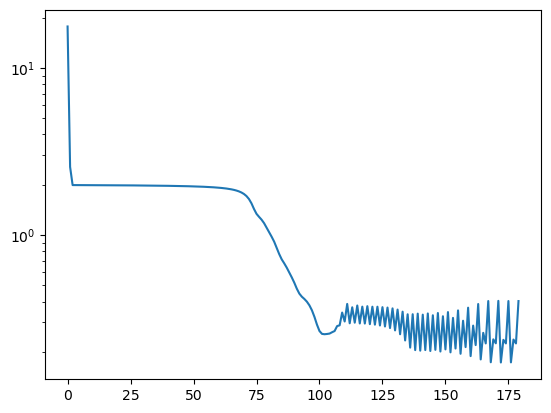

In [9]:
plt.figure()
# we use the ground state energy to push the energies into the positive regime
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value'] - ground_energy))
plt.show()

In [10]:
model = Jastrow()
params = model.init(jax.random.key(0), np.ones((hi.size, )))

lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=50, decay_rate=0.9)
optimizer = optax.adam(learning_rate=lr_schedule)
opt_state = optimizer.init(params)

logger = nk.logging.RuntimeLog()
for i in tqdm(range(300)):
    energy, grads = get_energy_grad(model, params, h)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    logger(step=i, item={'Energy': energy})

100%|██████████| 300/300 [00:11<00:00, 25.91it/s]


In [12]:
final_energy = get_energy(model, params, h)
print(f"Final Energy: {final_energy:.5f}")

Final Energy: -33.97007


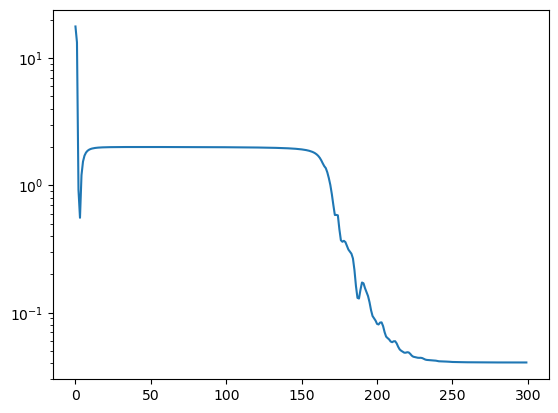

In [13]:
plt.figure()
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value'] - ground_energy))
plt.show()

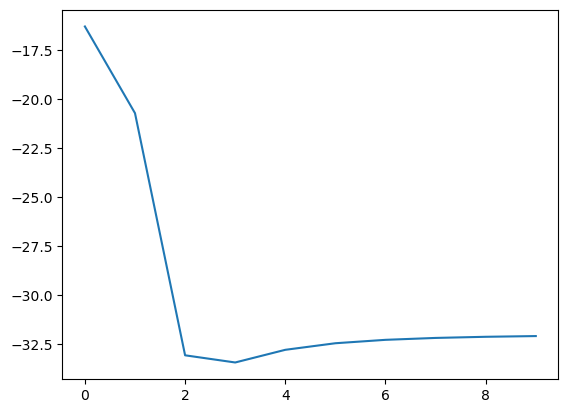

In [14]:
# only the first 10 epochs
plt.figure()
plt.plot(logger.data['Energy']['iters'][:10], logger.data['Energy']['value'][:10])
plt.show()

In [15]:
model = Jastrow()

# we know that the couplings are somewhere around +-0.02. We initialize by some normal enveloping them
key, subkey = jax.random.split(jax.random.PRNGKey(0))
params = model.init(key, 0.02 * jax.random.normal(subkey, shape=(hi.size,)))

lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=50, decay_rate=0.9)
optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=1e-4, b1=0.6, b2=0.99)
opt_state = optimizer.init(params)

logger = nk.logging.RuntimeLog()
for i in tqdm(range(100)):
    energy, grads = get_energy_grad(model, params, h)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    logger(step=i, item={'Energy': energy})

100%|██████████| 100/100 [00:03<00:00, 26.16it/s]


In [16]:
final_energy = get_energy(model, params, h)
print(f"Final Energy: {final_energy:.5f}")

Final Energy: -33.96986


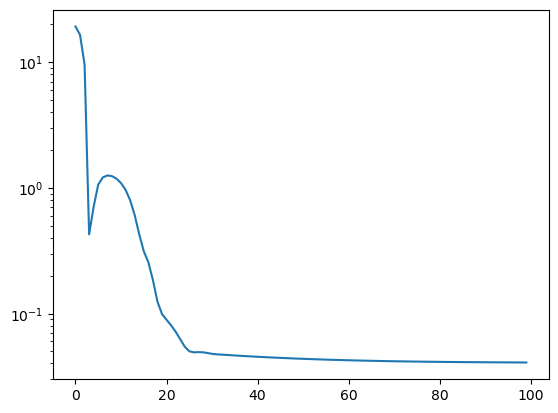

In [17]:
plt.figure()
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value'] - ground_energy))
plt.show()